In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.externals import joblib

%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def prep_data():
    """ returns a cleaned dataframe without target variable and a pandas series with the target 
        variable already modified to contain only 1 or 2 
        
    Returns
    -------
    X: pandas.DataFrame
        containing all the explanatory variables except the patient name and the target variable
    y: pandas.Series
        Containing only the target variabel "y" conatining only 2 values: 1 and 2
    """
    data = pd.read_csv("C:/Users/Basti/Documents/Bewerbungsunterlagen/DatSceintist/data.csv")
    X = data.drop(["Unnamed: 0", "y"], axis=1)
    y = data["y"].replace([2, 3, 4, 5], 2)
    return X, y


In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """ Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sb.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [4]:
def do_ROC_AUC_plot(actual, predictions):
    """ Generates a plot of ROC and AUC.
    
    Arguments
    ---------
    actual: pandas.series
        the test data for the target variable 
    prediction: np array
        The predictions from the model
    """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions, pos_label=2)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [5]:
# Loading the data and splitting it in training and test datasets
X, y = prep_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# A random forest should perform pretty good on this dataset without a dimensionality reduction using PCA or Feature selection. Let's see if that's actually true.

Testing score:  0.975362318841
precision score:  0.941007194245
Recall score:  0.936962750716


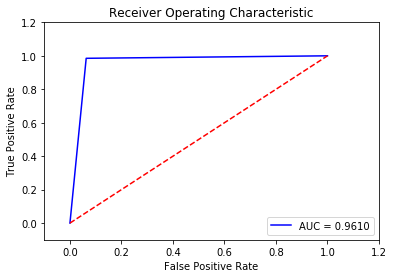

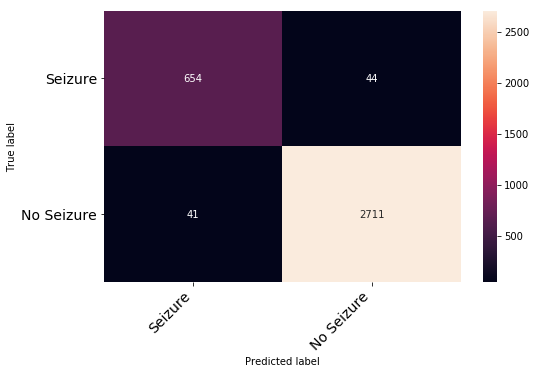

In [6]:
# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestClassifier(n_estimators=250))
        ])

# fitting the pipeline to the data
pipe = pipe.fit(X_train, y_train)

# predicting y
y_pred = pipe.predict(X_test)

# evaluating the results
print('Testing score: ', pipe.score(X_test, y_test))
print("precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

do_ROC_AUC_plot(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "No Seizure"], figsize = (8,5), fontsize=14)

# This looks pretty good for a first attempt! Just to be sure let's see how the combination of a logistic regression in combination with a PCA performs!

Testing score:  0.813333333333
precision score:  1.0
Recall score:  0.0773638968481


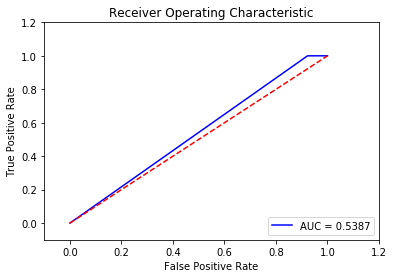

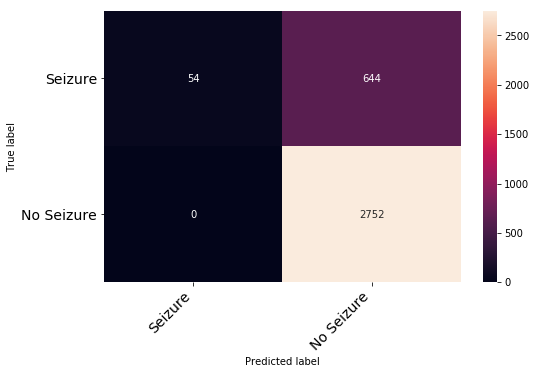

In [7]:
# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=70)),
        ('regressor', LogisticRegression())
        ])

# fitting the pipeline to the data and predicting y
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# evaluating the results
print('Testing score: ', pipe.score(X_test, y_test))
print("precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

do_ROC_AUC_plot(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "No Seizure"], figsize = (8,5), fontsize=14)

# The overall performance of the random fores is better, see ROC curve. However the logistic regression has a better precision but misses a lot more seizures (recall). As it's more important not to miss seizures (at least in my opinion), the Random Forest is the better choice.

# Can the random Forest be improved by adding a dimensionality reduction? n_components will be set to 70 as suggested in the data exploration notebook 

Testing score:  0.977101449275
precision score:  0.942775393419
Recall score:  0.944126074499


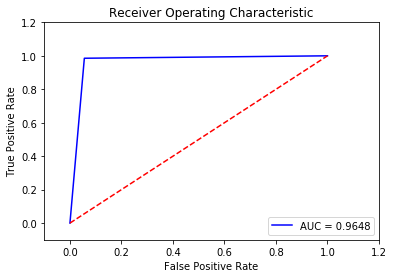

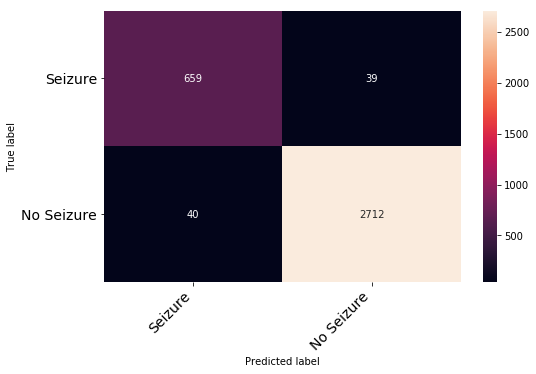

In [8]:
# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=70)),
        ('regressor', RandomForestClassifier(n_estimators=250))
        ])

# fitting the pipeline to the data
pipe = pipe.fit(X_train, y_train)

# predicting y
y_pred = pipe.predict(X_test)

# evaluating the results
print('Testing score: ', pipe.score(X_test, y_test))
print("precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

do_ROC_AUC_plot(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "No Seizure"], figsize = (8,5), fontsize=14)

# There is only a slight improvement. Before exploring further, let's check if the model is actually robust or just a lucky pick of data by doing a 10-fold cross validation.

In [76]:
# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=70)),
        ('regressor', RandomForestClassifier(n_estimators=250))
        ])

scores = cross_validation.cross_val_score(pipe, X, y, cv=10)
print(scores)


[ 0.97304348  0.97913043  0.97217391  0.97304348  0.9773913   0.97913043
  0.97478261  0.97304348  0.96869565  0.9773913 ]


In [84]:
scores.mean()

0.97478260869565214

# The model seems to be pretty robust!
# Let's see if we can get the number of missed Seizures down. The first data manipulation (changing all labels >2 to 2) might actually have been a not so good idea as the classes 2, 3, 4 and 5 might not overlap. In that case it's harder for the model to classify. So the next attempt is with the original dataset. For evaluation the labels are gonna be chaged after the prediction.

precision score:  0.924119241192
Recall score:  0.977077363897


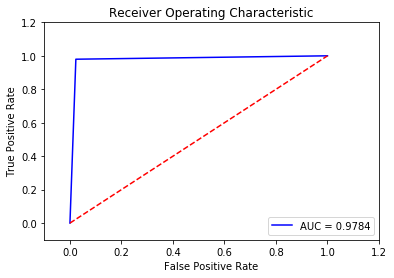

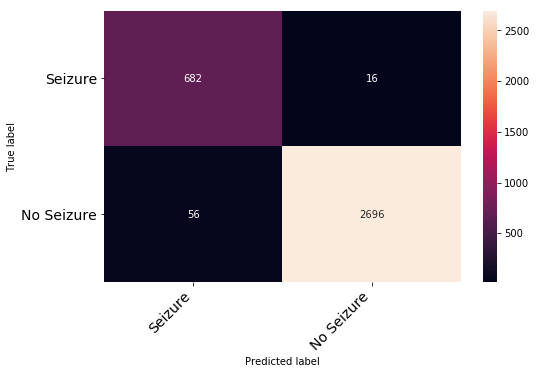

In [9]:
data = pd.read_csv("data.csv")
X_2 = data.drop(["Unnamed: 0", "y"], axis=1)
y_2 = data["y"]

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=70)),
        ('regressor', RandomForestClassifier(n_estimators=250))
        ])

# fitting the pipeline to the data
pipe = pipe.fit(X_train, y_train)

# predicting y
y_pred = pipe.predict(X_test)

# changing all y >2 to 2
y_pred[y_pred > 2] = 2
y_test[y_test > 2] = 2


# evaluating the results
print("precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

do_ROC_AUC_plot(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "No Seizure"], figsize = (8,5), fontsize=14)


# This improved the recall and reduced precision. As Recall is more important in this case and the precision decreased only by roughly as much as the recall increased, this modell is an improvemnt. The only caviat being that the output has to be modified to fit the binary classification. As a next step let's try to add weights to the classes to further improve the recall!

precision score:  0.900131406045
Recall score:  0.981375358166


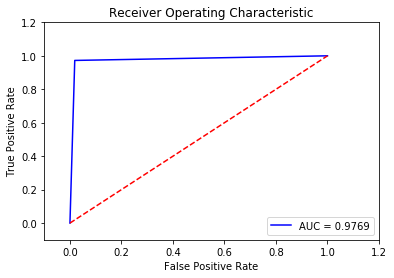

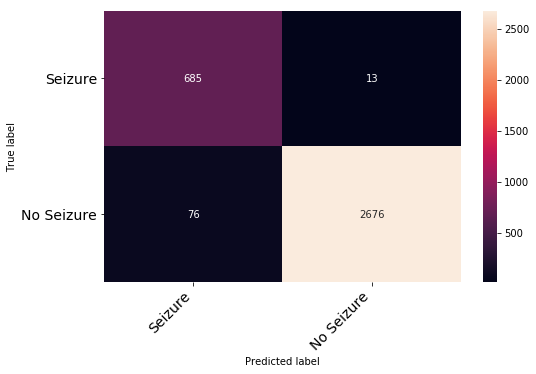

In [16]:
data = pd.read_csv("data.csv")
X_2 = data.drop(["Unnamed: 0", "y"], axis=1)
y_2 = data["y"]

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ("dim_reduction", PCA(n_components=70)),
        ('regressor', RandomForestClassifier(n_estimators=250, class_weight={1:5, 2:1, 3:1, 4:1, 5:1}))
        ])

# fitting the pipeline to the data
pipe = pipe.fit(X_train, y_train)

# predicting y
y_pred = pipe.predict(X_test)

# changing all y >2 to 2
y_pred[y_pred > 2] = 2
y_test[y_test > 2] = 2


# evaluating the results
print("precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

do_ROC_AUC_plot(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "No Seizure"], figsize = (8,5), fontsize=14)

# Adding wieghts and PCA gives the best model in terms of recall. Also the ROC curve looks pretty good. This model will now be exported for further usage.

In [17]:
# Exporting the pipeline for later use
filename = 'Seizure_model_binary.joblib.pkl'
_ = joblib.dump(pipe, filename, compress=9)